In [1]:
import sys

!{sys.executable} -m pip install pdfplumber requests

You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import requests
from pathlib import Path
import pandas as pd

cachedir = Path('cache')

cachedir.mkdir(parents=True, exist_ok=True)

def download_file(url, output_path):
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(output_path, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192): 
                f.write(chunk)

def download_reports_list():
    df_reports = pd.read_csv('https://raw.githubusercontent.com/J535D165/CoronaWatchNL/master/reports/reports_metadata.csv')
    
    for idx, row in df_reports.iterrows():
        outfile = cachedir / row['filename']
        if not outfile.exists():
            download_file(f'https://raw.githubusercontent.com/J535D165/CoronaWatchNL/master/reports/{row["filename"]}', outfile)

download_reports_list()

In [3]:
# ADD reports here if we want to be ahead of the curve (e.g. faster than CoronaWatchNL uploads / processes the data)

manual_reports = {
#    '20201117': 'https://www.rivm.nl/sites/default/files/2020-11/COVID-19_WebSite_rapport_wekelijks_20201117_1237.pdf'
}

for f in cachedir.glob('_MANUAL*.pdf'):
    f.unlink()
for f in cachedir.glob('_MANUAL*.json'):
    f.unlink()

for d, mr in manual_reports.items():
    if not mr:
        print(f'Skipping {d} no URL')
        continue
    if d not in mr:
        print(f'WARNING: {d} not in manually added report')
    download_file(mr, cachedir / f'_MANUAL_epidemiological_report_{d}.pdf')

In [4]:
import re
import json

def convert_to_text(file, ignore_cache=False):
    pages = []
    cachefile = cachedir / (file.resolve().stem + '.json')
    
    if not ignore_cache and cachefile.exists():
        with open(cachefile, 'r') as fh:
            return json.load(fh)
    
    with pdfplumber.open(file) as pdf:
        for page in pdf.pages:
            pages.append(page.extract_text())
            
    with open(cachefile, 'w') as fh:
        json.dump(pages, fh)
            
    return pages

def f20200929(date, page):
    groups = []
    if 'Aantal testen en percentage positief per doelgroep' in page and '0-3' in page:
        lines = page.splitlines()

        startparsing = False
        for line in lines:
            if 'Kinderen' in line:
                startparsing = True

            group = {}
            if startparsing:
                splitted = re.split('\s+', line)
                groupname = splitted[:-6]
                l = groupname[-1]
                if l[-1].isdigit() and not l[-2].isdigit():  # lets remove the trailing number that is sometimes present in a group name due to footnotes
                    groupname[-1] = groupname[-1][:-1]  

                groupname = ' '.join(groupname)

                if 'Overig/onbekend Getest' in groupname:  # correct some quirks in text extraction
                    groupname = 'Overig/onbekend'

                if 'ihkv BCO' in groupname:   # correct some quirks in text extraction
                    groupname = 'Getest ihkv BCO'

                group['date'] = date
                group['name'] = groupname
                nums = splitted[-6:]
                group['infected'] = nums[3]
                group['tested'] = nums[4]
                group['perc_positive'] = nums[5]

                groups.append(group)

            if 'Totaal' in line:
                startparsing = False
    return groups

process_funcs = {
    20200929: f20200929
}

files = list(cachedir.glob('*.pdf'))
counter = 1
                
def pergroupandpercpositive(date, pages):
    groups = []
    
    # decide which version of the report extraction function we should use
    try:
        f = max([a for a in process_funcs.keys() if a-int(date) <= 0])  # get closest match that is equal but certainly not larger than date of report
    except ValueError as e:
        if 'empty sequence' not in str(e):
            raise e  # reraise, this is not an expected error
        f = None

    if f is None:
        print(f'No extractor function for report on {date}')
        return None
    
    for page in pages:
        g = process_funcs[f](date, page)
        
        if g:
            groups += g
    
    if not groups:
        print(f'WARNING: extractor for report {date} but no data found!')
    
    return groups
                
datas = []
for file in files:
    print(f'Working on {counter}/{len(files)} {file.name}')
    counter += 1
    if 'epidemiological_report' in file.name:
        pages = convert_to_text(file)
        date = file.name.split('_')[-1].split('.')[0]
        data = pergroupandpercpositive(date, pages)
        if data:
            datas += data

Working on 1/119 COVID-19_epidemiological_report_20200515.pdf
No extractor function for report on 20200515
Working on 2/119 COVID-19_epidemiological_report_20201006.pdf
Working on 3/119 COVID-19_epidemiological_report_20200517.pdf
No extractor function for report on 20200517
Working on 4/119 COVID-19_epidemiological_report_20200514.pdf
No extractor function for report on 20200514
Working on 5/119 COVID-19_epidemiological_report_20201020.pdf
Working on 6/119 COVID-19_epidemiological_report_20200329.pdf
No extractor function for report on 20200329
Working on 7/119 COVID-19_epidemiological_report_20200501.pdf
No extractor function for report on 20200501
Working on 8/119 COVID-19_epidemiological_report_20200419.pdf
No extractor function for report on 20200419
Working on 9/119 COVID-19_epidemiological_report_20200811.pdf
No extractor function for report on 20200811
Working on 10/119 COVID-19_epidemiological_report_20200520.pdf
No extractor function for report on 20200520
Working on 11/119 C

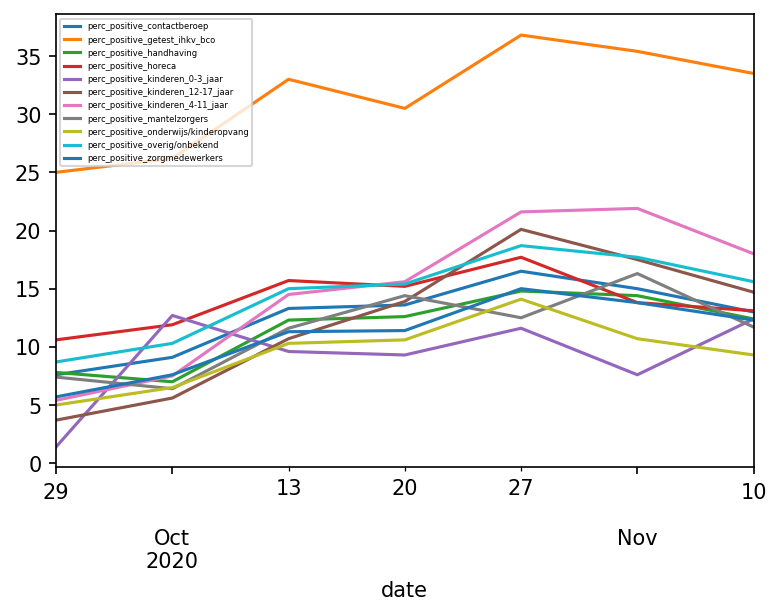

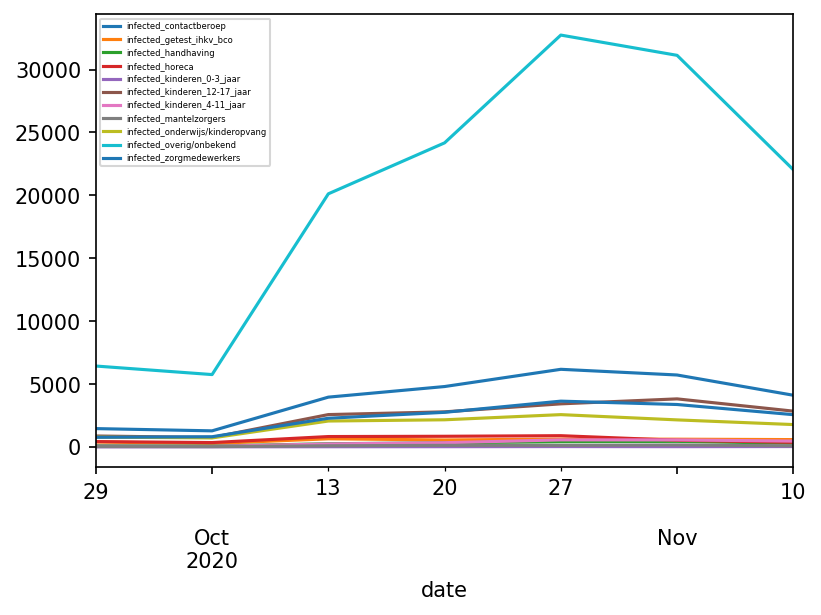

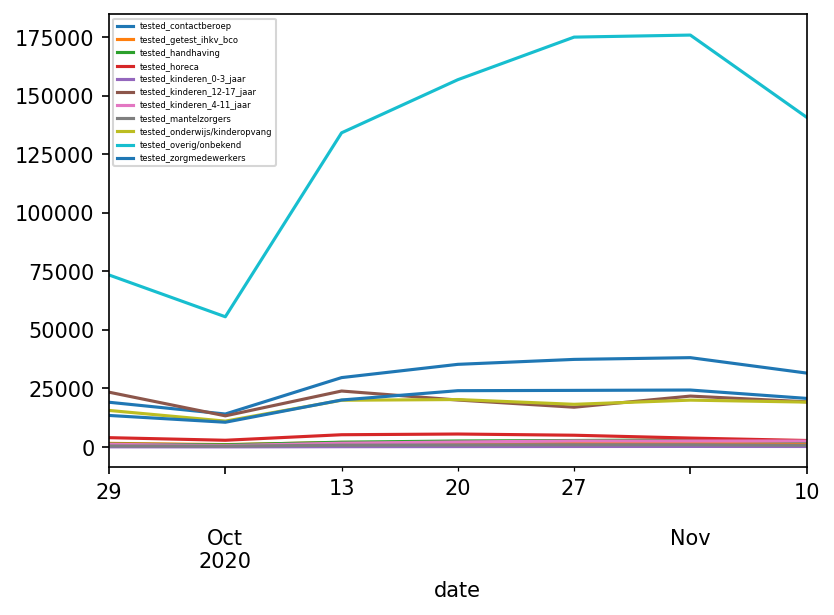

In [5]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 150

df_distri = pd.DataFrame(datas).set_index('date')
df_distri.index = pd.to_datetime(df_distri.index)
df_distri = df_distri.sort_index()

df_distri = df_distri.pivot(columns='name', values=['infected', 'tested', 'perc_positive'])

df_distri.columns = ['_'.join(col).strip().lower().replace(' ', '_') for col in df_distri.columns.values]  # unstack multi-col

# plot percentage positive but skip total
cols = [c for c in df_distri.columns if 'perc_' in c and not 'totaal' in c]
ax = df_distri[cols].astype(float).plot()
ax.legend(loc=2, prop={'size': 4})

# plot tested positive aka infected but skip total
cols = [c for c in df_distri.columns if 'infected_' in c and not 'totaal' in c]
ax = df_distri[cols].astype(float).plot()
ax.legend(loc=2, prop={'size': 4})

# plot total tested but skip total
cols = [c for c in df_distri.columns if 'tested_' in c and not 'totaal' in c]
ax = df_distri[cols].astype(float).plot()
ax.legend(loc=2, prop={'size': 4})

df_distri.astype(float).to_csv('testing-per-group.csv')  # output dataframe to csv